In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import hmp
from pathlib import Path
import os
import xarray as xr
from tqdm.notebook import tqdm
import mne
from mne.preprocessing import find_bad_channels_lof, ICA
from autoreject import AutoReject
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [3]:
eeg_path = DATA_PATH / "prp2"

In [4]:
import pandas as pd
behav_path = eeg_path / "Behavioral_data.xlsx"

df = pd.read_excel(behav_path)

/opt/conda/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


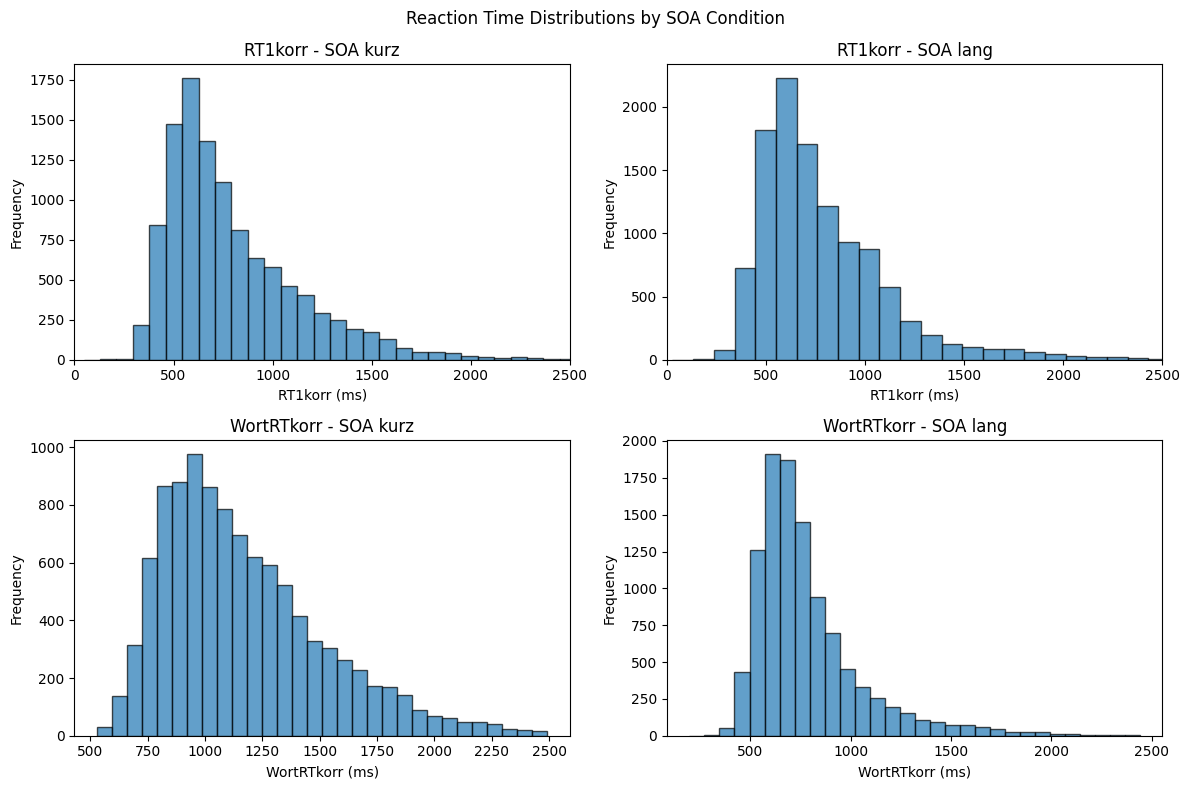

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Reaction Time Distributions by SOA Condition')

# RT1korr by SOA
for i, soa in enumerate(['kurz', 'lang']):
    data = df[df['SOA'] == soa]['RT1korr'].dropna()
    axes[0, i].hist(data, bins=30, alpha=0.7, edgecolor='black')
    axes[0, i].set_title(f'RT1korr - SOA {soa}')
    axes[0, i].set_xlabel('RT1korr (ms)')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].set_xlim(0, 2500)

# WortRTkorr by SOA
for i, soa in enumerate(['kurz', 'lang']):
    data = df[df['SOA'] == soa]['WortRTkorr'].dropna()
    axes[1, i].hist(data, bins=30, alpha=0.7, edgecolor='black')
    axes[1, i].set_title(f'WortRTkorr - SOA {soa}')
    axes[1, i].set_xlabel('WortRTkorr (ms)')
    axes[1, i].set_ylabel('Frequency')
    axes[0, i].set_xlim(0, 2500)


plt.tight_layout()
plt.show()

In [4]:
def match_metadata(epochs, df_p, infos, stim_event_ids):
    """ Match metadata from df_p to epochs based on Ton, Bedingung, SOA """
    stim_event_ids = {v: k for k, v in stim_event_ids.items()}
    df_p = df_p.sort_values(by='Item').reset_index(drop=True)
    
    metadata_rows = []
    df_idx = 0  # Index for df_p
    
    for i, (epoch, info) in enumerate(zip(epochs, infos)):
        # Extract epoch characteristics
        tone = int(stim_event_ids[info[0]])
        word_cond = stim_event_ids[info[1]]
        soa = 'kurz' if info[2] < 200 else 'lang'
        
        # Find matching row in df_p starting from current df_idx
        matched = False
        start_idx = df_idx
        
        while df_idx < len(df_p):
            row = df_p.iloc[df_idx]
            
            # Check if this row matches the current epoch
            if (row['Ton'] == tone and 
                row['Bedingung'][:3] == word_cond and 
                row['SOA'] == soa):
                metadata_rows.append(row)
                df_idx += 1  # Move to next row for next epoch
                matched = True
                break
            
            df_idx += 1
            
            # Prevent infinite loop
            if df_idx - start_idx > 75:
                break
        
        if not matched:
            metadata_rows.append({'Ton': tone, 'Bedingung': word_cond, 'SOA': soa})
            raise ValueError(f"Could not find matching row for epoch {i} with Ton={tone}, Bedingung={word_cond}, SOA={soa}")
    
    metadata = pd.DataFrame(metadata_rows).reset_index(drop=True)
    epochs.metadata = metadata
    return epochs

In [5]:
paths = list(eeg_path.glob("*.cnt"))
# paths = [path for path in paths if "17" in path.stem]

In [7]:
sfreq = 500
SOA_SHORT = int(0.1 * sfreq)  # 100 ms
SOA_LONG = int(0.7 * sfreq)   # 700 ms
SLACK_SAMPLES = 25  # 50 ms, same as in original analysis
T1_CODES = ['150', '160']
T2_CODES = ['202', '204', '214', '212', '213', '203', '201', '211']
eeg_path = DATA_PATH / "prp2"
out_path = eeg_path / 'processed'

for file in paths:
    p = file.stem
    print(f"Processing P{p}")
    if (out_path / f"P{p}_T1-epo.fif").exists() and (out_path / f"P{p}_T2-epo.fif").exists():
        continue
    if p in ["01", "18b", "12c", "12b", "17b", "19b", "02_07xx"]:
        continue # These versions of raw data are different sessions?
    eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)

    channels_to_drop = ['M1', 'M2', 'CB1', 'CB2']
    # Set EOG channel types properly
    if 'VEO' in eeg.ch_names:
        eeg.set_channel_types({'VEO': 'eog'})
    if 'HEO' in eeg.ch_names:
        eeg.set_channel_types({'HEO': 'eog'})

    eeg.drop_channels([ch for ch in channels_to_drop if ch in eeg.ch_names])
    channel_mapping = {
        'FP1': 'Fp1', 'FPZ': 'Fpz', 'FP2': 'Fp2',
        'FZ': 'Fz', 'FCZ': 'FCz', 'CZ': 'Cz', 
        'CPZ': 'CPz', 'PZ': 'Pz', 'POZ': 'POz',
        'OZ': 'Oz'
    }
    eeg.rename_channels(channel_mapping)
    eeg.set_montage("standard_1005")

    eeg.set_eeg_reference('average', ch_type='eeg', projection=False)
    eeg.filter(l_freq=0.1, h_freq=40, fir_design='firwin', verbose=False)

    df_p = df[df['VP'] == p]
    if len(df_p) == 0:
        print("  No behavioral data")
        p = p[:2]
        df_p = df[df['VP'] == p]

    events, event_id = mne.events_from_annotations(eeg, verbose=False)
    t1_codes = [event_id[marker] for marker in T1_CODES if marker in event_id]
    t2_codes = [event_id[marker] for marker in T2_CODES if marker in event_id]
    
    valid_t1_indices = []
    valid_t2_indices = []
    valid_epoch_infos = []

    for i, event in enumerate(events):
        if event[2] in t1_codes:
            t1_time = event[0]

            t2_found = False
            for j in range(i + 1, len(events)):
                t2_event = events[j]
                if t2_event[2] in t2_codes:
                    soa = t2_event[0] - t1_time

                    if soa > SOA_LONG + SLACK_SAMPLES:
                        break
                    if (soa >= SOA_SHORT - SLACK_SAMPLES and soa <= SOA_SHORT + SLACK_SAMPLES) or \
                       (soa >= SOA_LONG - SLACK_SAMPLES and soa <= SOA_LONG + SLACK_SAMPLES):
                        valid_t1_indices.append(i)
                        valid_t2_indices.append(j)
                        valid_epoch_info = (event[2], t2_event[2], soa)
                        valid_epoch_infos.append(valid_epoch_info)
                        t2_found = True
                    break
            if not t2_found:
                print(f"T1 at sample {t1_time} has no valid T2")
    all_valid_indices = list(set(valid_t1_indices + valid_t2_indices))
    filtered_events = events[all_valid_indices]
    print(f"P{p} Original events: {len(events)} (also includes other events), Filtered events: {len(filtered_events)}")

    stim_event_ids_t1 = {k: v for k, v in event_id.items() if k in T1_CODES}
    stim_event_ids_t2 = {k: v for k, v in event_id.items() if k in T2_CODES}
    
    # T1 Epochs
    epochs_t1 = mne.Epochs(eeg, filtered_events[ [i for i in range(len(filtered_events)) if filtered_events[i,2] in t1_codes] ], event_id=stim_event_ids_t1, tmin=-0.2, tmax=3.2, baseline=None, preload=True)
    epochs_t1 = match_metadata(epochs_t1, df_p, valid_epoch_infos, {**stim_event_ids_t1, **stim_event_ids_t2})

    # T2 Epochs
    epochs_t2 = mne.Epochs(eeg, filtered_events[ [i for i in range(len(filtered_events)) if filtered_events[i,2] in t2_codes] ], event_id=stim_event_ids_t2, tmin=-0.2, tmax=2.5, baseline=None, preload=True)
    epochs_t2 = match_metadata(epochs_t2, df_p, valid_epoch_infos, {**stim_event_ids_t1, **stim_event_ids_t2})
    print(f"  Created {len(epochs_t1)} T1 epochs and {len(epochs_t2)} T2 epochs")

    # Filter out trials where RT1korr < 700ms in lang SOA condition to remove overlap
    valid_mask = ((epochs_t1.metadata['RT1korr'] < 700) & (epochs_t1.metadata['SOA'] == 'lang')) | (epochs_t1.metadata['SOA'] == 'kurz')
    print(valid_mask.sum() / len(valid_mask) * 100, "% of trials kept after RT1 < 700ms filter in lang SOA")
    epochs_t1 = epochs_t1[valid_mask]
    epochs_t2 = epochs_t2[valid_mask]
    
    ar = AutoReject(n_interpolate=[1, 2, 3, 4], n_jobs=12, verbose=True)
    ar.fit(epochs_t1[0:50])
    epochs_t1_clean, reject_log_t1 = ar.transform(epochs_t1, return_log=True)
    epochs_t2_clean, reject_log_t2 = ar.transform(epochs_t2, return_log=True)
    # Find epochs that are bad in either T1 or T2
    kept_indices_t1 = np.where(~reject_log_t1.bad_epochs)[0]
    kept_indices_t2 = np.where(~reject_log_t2.bad_epochs)[0]

    # Find intersection of kept indices
    common_indices = np.intersect1d(kept_indices_t1, kept_indices_t2)
    t1_mask = np.isin(kept_indices_t1, common_indices)
    epochs_t1 = epochs_t1_clean[t1_mask]
    t2_mask = np.isin(kept_indices_t2, common_indices)
    epochs_t2 = epochs_t2_clean[t2_mask]
    print(f"  Kept {len(epochs_t1)} epochs after joint T1/T2 artifact rejection")

    # Eye-blink T1
    ica = ICA(n_components=0.99, random_state=42, verbose=False)
    ica.fit(epochs_t1, picks=['eeg'], verbose=False)
    eog_indices, _ = ica.find_bads_eog(epochs_t1, ch_name=['VEO', 'HEO'], verbose=False)
    ica.exclude = eog_indices
    print(f"  EOG components excluded (T1): {eog_indices}")
    if len(eog_indices) > 0:
        epochs_t1 = ica.apply(epochs_t1, verbose=False)
    epochs_t1.drop_channels(['VEO', 'HEO'], on_missing='ignore')

    # Eye-blink T2
    eog_indices, _ = ica.find_bads_eog(epochs_t2, ch_name=['VEO', 'HEO'], verbose=False)
    ica.exclude = eog_indices
    print(f"  EOG components excluded (T2): {eog_indices}")
    if len(eog_indices) > 0:
        epochs_t2 = ica.apply(epochs_t2, verbose=False)
    epochs_t2.drop_channels(['VEO', 'HEO'], on_missing='ignore')

    # Get all T1 data at once
    t1_data_all = epochs_t1.get_data()  # Shape: (n_epochs, n_channels, n_times)
    t2_data_all = epochs_t2.get_data()  # Shape: (n_epochs, n_channels, n_times)
    
    # Calculate baseline from T1 (first 0.2s)
    baseline_samples = int(sfreq * 0.2)
    t1_baseline = t1_data_all[:, :, :baseline_samples].mean(axis=2, keepdims=True)  # Shape: (n_epochs, n_channels, 1)
    
    # Apply baseline correction to all epochs at once
    t1_corrected = t1_data_all - t1_baseline
    t2_corrected = t2_data_all - t1_baseline
    
    # Update the epochs data
    epochs_t1._data = t1_corrected
    epochs_t2._data = t2_corrected
    
    epochs_t1.save(out_path / f"P{p}_T1-epo.fif", overwrite=True)
    epochs_t2.save(out_path / f"P{p}_T2-epo.fif", overwrite=True)
    

Processing P01
Processing P22


/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 618611 has no valid T2
T1 at sample 860118 has no valid T2
P22 Original events: 4874 (also includes other events), Filtered events: 1916
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 958 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 958 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 958 T1 epochs and 958 T2 epochs
63.04801670146137 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=3


  0%|          | Repairing epochs : 0/604 [00:00<?,       ?it/s]

Dropped 340 epochs: 1, 2, 5, 19, 27, 28, 30, 33, 34, 36, 38, 41, 43, 45, 49, 52, 54, 55, 66, 69, 72, 73, 74, 77, 81, 82, 85, 93, 94, 96, 101, 103, 104, 107, 110, 112, 115, 116, 117, 120, 122, 126, 130, 132, 133, 135, 137, 138, 144, 148, 151, 153, 158, 159, 160, 162, 163, 166, 167, 170, 171, 173, 174, 176, 179, 181, 182, 183, 185, 187, 189, 190, 191, 192, 194, 198, 199, 203, 206, 209, 211, 216, 218, 223, 224, 227, 228, 231, 234, 236, 238, 240, 242, 244, 250, 256, 258, 259, 260, 262, 264, 267, 269, 270, 274, 275, 277, 279, 283, 285, 290, 293, 295, 296, 298, 299, 300, 302, 303, 304, 306, 308, 310, 312, 314, 316, 317, 318, 319, 321, 323, 324, 325, 326, 327, 328, 331, 332, 336, 337, 340, 341, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 357, 358, 359, 360, 362, 364, 366, 367, 369, 372, 374, 375, 376, 377, 378, 380, 382, 383, 387, 388, 389, 390, 391, 392, 393, 396, 397, 398, 399, 401, 402, 406, 409, 410, 413, 414, 415, 416, 417, 420, 421, 423, 425, 426, 428, 430, 431, 433, 434

  0%|          | Repairing epochs : 0/604 [00:00<?,       ?it/s]

Dropped 319 epochs: 2, 19, 27, 30, 33, 34, 36, 38, 41, 43, 49, 52, 54, 55, 66, 69, 72, 73, 74, 77, 81, 82, 85, 94, 96, 101, 103, 104, 107, 112, 115, 116, 117, 120, 122, 126, 130, 132, 133, 135, 137, 144, 148, 151, 153, 158, 159, 160, 162, 163, 166, 167, 170, 171, 173, 174, 176, 179, 181, 182, 183, 185, 187, 189, 190, 191, 192, 194, 198, 199, 203, 206, 209, 211, 216, 218, 223, 224, 227, 228, 231, 234, 236, 238, 240, 242, 244, 250, 256, 258, 259, 260, 262, 264, 267, 269, 270, 274, 277, 279, 283, 285, 290, 295, 296, 298, 299, 300, 302, 303, 304, 306, 308, 310, 312, 314, 316, 317, 318, 319, 321, 323, 324, 325, 327, 328, 331, 332, 336, 337, 340, 341, 344, 345, 346, 347, 348, 349, 350, 351, 352, 354, 355, 357, 358, 359, 362, 364, 366, 367, 369, 372, 374, 375, 376, 380, 382, 383, 387, 388, 389, 390, 391, 392, 396, 397, 398, 399, 402, 406, 409, 410, 413, 414, 415, 416, 417, 420, 421, 423, 425, 426, 428, 430, 431, 433, 434, 435, 436, 437, 438, 440, 442, 443, 445, 447, 449, 450, 451, 452, 453, 4

/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 290304 has no valid T2
P21 Original events: 4851 (also includes other events), Filtered events: 1918
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 959 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 959 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 959 T1 epochs and 959 T2 epochs
71.53284671532847 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=1


  0%|          | Repairing epochs : 0/686 [00:00<?,       ?it/s]

Dropped 14 epochs: 47, 52, 56, 164, 316, 354, 453, 496, 543, 548, 570, 580, 623, 678


  0%|          | Repairing epochs : 0/686 [00:00<?,       ?it/s]

Dropped 11 epochs: 47, 52, 56, 164, 316, 496, 543, 570, 580, 623, 678
  Kept 672 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): []
  EOG components excluded (T2): []
Processing P06
Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 1098640 has no valid T2
T1 at sample 1354137 has no valid T2
P06 Original events: 4885 (also includes other events), Filtered events: 1916
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 958 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 958 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 958 T1 epochs and 958 T2 epochs
76.40918580375782 % of trials kept after RT1 < 700ms

  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/732 [00:00<?,       ?it/s]

Dropped 210 epochs: 30, 35, 39, 43, 56, 58, 59, 60, 63, 64, 70, 71, 93, 117, 129, 144, 147, 149, 151, 155, 156, 159, 163, 164, 166, 168, 169, 170, 177, 182, 183, 184, 185, 202, 203, 224, 229, 230, 233, 234, 237, 242, 244, 253, 264, 274, 275, 280, 281, 283, 285, 286, 291, 300, 304, 309, 312, 317, 318, 330, 336, 338, 339, 344, 346, 348, 350, 356, 357, 361, 362, 368, 370, 379, 382, 385, 388, 391, 405, 406, 407, 413, 414, 415, 416, 419, 420, 422, 424, 425, 427, 430, 431, 434, 436, 437, 438, 439, 440, 443, 444, 446, 451, 457, 460, 461, 463, 464, 465, 467, 470, 472, 476, 480, 488, 489, 490, 491, 492, 496, 497, 498, 501, 505, 508, 510, 512, 515, 516, 517, 522, 524, 529, 532, 534, 538, 545, 551, 554, 555, 556, 563, 566, 568, 570, 572, 573, 574, 575, 576, 578, 579, 581, 584, 585, 587, 588, 591, 592, 595, 596, 599, 601, 605, 608, 611, 612, 614, 617, 623, 624, 625, 627, 631, 634, 638, 639, 644, 645, 646, 647, 655, 656, 661, 667, 668, 671, 673, 676, 678, 679, 694, 695, 697, 698, 699, 700, 701, 707

  0%|          | Repairing epochs : 0/732 [00:00<?,       ?it/s]

Dropped 121 epochs: 35, 56, 58, 60, 64, 71, 129, 147, 159, 163, 168, 169, 177, 182, 185, 203, 224, 229, 234, 237, 274, 275, 280, 281, 283, 285, 286, 291, 304, 317, 318, 336, 339, 344, 356, 361, 370, 379, 382, 391, 407, 414, 415, 416, 422, 424, 430, 431, 436, 437, 438, 439, 446, 457, 464, 465, 467, 470, 490, 496, 497, 498, 501, 505, 508, 510, 512, 515, 516, 517, 522, 524, 532, 551, 554, 555, 556, 563, 568, 572, 573, 575, 576, 578, 579, 581, 585, 588, 591, 596, 599, 605, 608, 611, 612, 623, 624, 631, 638, 639, 644, 645, 646, 655, 656, 661, 667, 668, 671, 678, 694, 697, 700, 701, 707, 713, 715, 722, 725, 728, 729
  Kept 522 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(1), np.int64(3), np.int64(17)]
  EOG components excluded (T2): [np.int64(0), np.int64(1), np.int64(3), np.int64(17)]
Processing P05
Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 1035092 has no valid T2
P05 Original events: 4892 (also inclu

  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=3


  0%|          | Repairing epochs : 0/865 [00:00<?,       ?it/s]

Dropped 98 epochs: 3, 7, 8, 10, 12, 14, 17, 20, 23, 29, 32, 34, 36, 39, 43, 45, 49, 52, 53, 56, 58, 63, 64, 65, 69, 72, 73, 75, 78, 84, 87, 88, 89, 90, 93, 97, 98, 102, 107, 109, 112, 113, 123, 125, 128, 131, 143, 159, 162, 169, 171, 206, 218, 227, 267, 275, 283, 310, 321, 383, 387, 393, 412, 448, 462, 465, 490, 495, 498, 499, 503, 504, 513, 518, 545, 547, 548, 576, 588, 600, 626, 651, 664, 677, 696, 700, 703, 704, 725, 732, 744, 750, 760, 768, 782, 783, 821, 855


  0%|          | Repairing epochs : 0/865 [00:00<?,       ?it/s]

Dropped 83 epochs: 3, 7, 8, 10, 12, 14, 17, 20, 23, 29, 32, 34, 36, 39, 43, 49, 52, 53, 58, 63, 64, 69, 72, 73, 78, 84, 87, 88, 89, 90, 93, 97, 98, 102, 107, 109, 112, 113, 123, 125, 128, 131, 143, 159, 162, 169, 171, 206, 218, 267, 283, 321, 383, 393, 412, 448, 462, 465, 490, 495, 498, 499, 503, 504, 518, 545, 547, 548, 588, 600, 626, 677, 700, 703, 704, 725, 732, 744, 750, 768, 783, 821, 855
  Kept 767 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(24)]
  EOG components excluded (T2): [np.int64(0), np.int64(24)]
Processing P16


/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 419110 has no valid T2
T1 at sample 891920 has no valid T2
P16 Original events: 4861 (also includes other events), Filtered events: 1916
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 958 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 958 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 958 T1 epochs and 958 T2 epochs
71.71189979123173 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=3


  0%|          | Repairing epochs : 0/687 [00:00<?,       ?it/s]

Dropped 133 epochs: 31, 51, 67, 71, 87, 89, 101, 102, 109, 146, 148, 149, 155, 192, 195, 196, 198, 226, 229, 242, 249, 254, 257, 258, 275, 278, 281, 283, 285, 288, 302, 312, 330, 332, 334, 336, 339, 342, 344, 349, 354, 355, 362, 366, 368, 374, 376, 377, 378, 382, 385, 387, 401, 402, 403, 411, 416, 420, 423, 424, 425, 428, 442, 444, 451, 455, 458, 461, 465, 467, 469, 470, 477, 481, 482, 485, 487, 491, 494, 497, 502, 505, 507, 512, 513, 531, 532, 534, 539, 540, 543, 545, 548, 549, 551, 552, 553, 556, 557, 569, 573, 577, 580, 584, 585, 586, 588, 589, 590, 593, 596, 611, 612, 617, 620, 622, 627, 629, 631, 636, 643, 645, 646, 648, 652, 654, 658, 663, 667, 671, 675, 678, 681


  0%|          | Repairing epochs : 0/687 [00:00<?,       ?it/s]

Dropped 111 epochs: 31, 51, 67, 87, 89, 101, 102, 146, 148, 149, 155, 192, 195, 196, 198, 226, 229, 249, 254, 257, 258, 278, 281, 283, 285, 288, 312, 332, 334, 336, 339, 342, 344, 349, 362, 366, 368, 374, 376, 377, 382, 385, 387, 401, 403, 411, 416, 420, 423, 424, 425, 428, 442, 444, 451, 455, 461, 465, 467, 477, 481, 482, 485, 487, 491, 494, 502, 507, 512, 513, 531, 532, 534, 539, 540, 543, 545, 548, 551, 552, 553, 556, 569, 573, 577, 580, 584, 586, 590, 593, 611, 612, 617, 620, 622, 627, 629, 631, 636, 643, 645, 646, 652, 654, 658, 663, 667, 671, 675, 678, 681
  Kept 554 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(2), np.int64(18), np.int64(8)]
  EOG components excluded (T2): [np.int64(0), np.int64(2), np.int64(18), np.int64(8)]
Processing P15


/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 429637 has no valid T2
T1 at sample 451285 has no valid T2
T1 at sample 557208 has no valid T2
P15 Original events: 4922 (also includes other events), Filtered events: 1914
Not setting metadata
957 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 957 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
957 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 957 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 957 T1 epochs and 957 T2 epochs
95.61128526645768 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=1


  0%|          | Repairing epochs : 0/915 [00:00<?,       ?it/s]

Dropped 94 epochs: 3, 16, 57, 59, 92, 112, 148, 208, 283, 308, 318, 320, 346, 357, 380, 384, 400, 403, 405, 412, 413, 421, 426, 429, 443, 450, 451, 458, 459, 463, 464, 465, 466, 471, 484, 492, 495, 496, 509, 521, 531, 564, 574, 576, 577, 579, 581, 584, 608, 612, 622, 625, 641, 673, 677, 680, 684, 688, 689, 693, 694, 695, 697, 706, 707, 716, 722, 738, 740, 745, 749, 754, 755, 756, 757, 758, 764, 765, 771, 775, 781, 797, 798, 806, 807, 812, 814, 855, 864, 865, 867, 868, 872, 906


  0%|          | Repairing epochs : 0/915 [00:00<?,       ?it/s]

Dropped 70 epochs: 3, 16, 59, 92, 112, 148, 208, 283, 308, 318, 320, 357, 380, 384, 400, 403, 405, 413, 421, 426, 429, 443, 450, 459, 465, 466, 471, 484, 492, 495, 496, 509, 521, 531, 564, 577, 579, 581, 584, 612, 622, 625, 641, 680, 684, 688, 689, 693, 694, 695, 706, 716, 722, 740, 745, 749, 754, 756, 757, 758, 765, 775, 797, 798, 807, 814, 855, 867, 868, 906
  Kept 821 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(8), np.int64(2), np.int64(6)]
  EOG components excluded (T2): [np.int64(0), np.int64(8), np.int64(2), np.int64(6)]
Processing P13


/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 125283 has no valid T2
T1 at sample 1552553 has no valid T2
P13 Original events: 4883 (also includes other events), Filtered events: 1916
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 958 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 958 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 958 T1 epochs and 958 T2 epochs
76.30480167014613 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/731 [00:00<?,       ?it/s]

Dropped 411 epochs: 0, 2, 3, 5, 9, 10, 11, 12, 13, 17, 21, 22, 24, 25, 26, 27, 28, 31, 33, 35, 39, 40, 49, 50, 51, 52, 54, 58, 61, 62, 65, 66, 67, 68, 72, 73, 74, 77, 78, 79, 80, 83, 84, 86, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 107, 114, 118, 119, 120, 123, 125, 128, 131, 132, 137, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 156, 157, 162, 165, 166, 167, 168, 169, 171, 175, 180, 181, 182, 187, 188, 190, 191, 192, 194, 195, 196, 198, 199, 201, 202, 206, 209, 215, 222, 228, 229, 232, 233, 234, 238, 240, 241, 242, 243, 247, 248, 249, 250, 251, 253, 254, 255, 257, 258, 259, 260, 261, 262, 264, 273, 280, 283, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 302, 303, 305, 306, 307, 308, 310, 311, 312, 313, 315, 318, 319, 320, 323, 325, 328, 332, 339, 341, 343, 345, 346, 347, 348, 350, 353, 355, 366, 367, 375, 376, 378, 379, 381, 383, 384, 385, 389, 391, 393, 394, 395, 396, 397, 398, 399, 400, 401, 405, 406, 407, 408, 

  0%|          | Repairing epochs : 0/731 [00:00<?,       ?it/s]

Dropped 364 epochs: 0, 2, 3, 5, 10, 11, 12, 13, 17, 21, 22, 24, 25, 26, 27, 28, 31, 33, 35, 39, 49, 50, 51, 52, 54, 58, 61, 62, 65, 66, 67, 68, 72, 74, 77, 78, 80, 83, 84, 86, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 107, 114, 123, 125, 128, 131, 132, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 156, 157, 162, 166, 167, 168, 169, 171, 175, 180, 181, 182, 187, 188, 190, 192, 194, 195, 196, 198, 199, 201, 202, 206, 222, 228, 234, 238, 241, 242, 243, 247, 248, 249, 250, 251, 253, 255, 257, 258, 259, 260, 261, 262, 273, 280, 283, 286, 287, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 303, 305, 306, 307, 310, 311, 312, 313, 318, 319, 320, 323, 328, 332, 339, 345, 346, 347, 348, 350, 353, 355, 366, 367, 375, 376, 378, 379, 381, 383, 384, 385, 389, 391, 393, 394, 395, 396, 397, 398, 399, 400, 401, 405, 406, 407, 408, 409, 410, 411, 413, 414, 415, 418, 419, 420, 421, 422, 426, 427, 432, 434, 435, 439, 440, 441, 442, 443, 444, 445, 446, 447, 451, 

/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 800219 has no valid T2
P03 Original events: 4911 (also includes other events), Filtered events: 1918
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 959 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 959 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 959 T1 epochs and 959 T2 epochs
83.52450469238791 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=3


  0%|          | Repairing epochs : 0/801 [00:00<?,       ?it/s]

Dropped 427 epochs: 0, 1, 5, 15, 21, 28, 35, 39, 44, 48, 49, 55, 56, 58, 61, 63, 66, 67, 72, 76, 78, 82, 83, 86, 91, 94, 97, 98, 99, 101, 102, 106, 110, 113, 115, 117, 118, 120, 123, 124, 125, 127, 128, 132, 135, 136, 137, 139, 140, 142, 143, 145, 146, 147, 149, 151, 152, 155, 159, 160, 161, 163, 166, 170, 172, 175, 176, 177, 180, 182, 185, 186, 190, 192, 193, 196, 200, 202, 203, 204, 205, 207, 210, 213, 217, 218, 220, 221, 223, 224, 227, 233, 234, 236, 238, 239, 241, 248, 250, 252, 253, 254, 255, 264, 266, 268, 269, 270, 271, 272, 275, 276, 277, 278, 279, 281, 282, 283, 284, 289, 290, 291, 292, 294, 297, 299, 300, 302, 303, 304, 305, 306, 307, 310, 312, 315, 316, 318, 319, 320, 321, 323, 324, 326, 327, 329, 331, 332, 333, 334, 335, 336, 337, 339, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 354, 355, 359, 360, 361, 363, 365, 367, 369, 371, 373, 376, 378, 379, 381, 382, 383, 386, 387, 389, 392, 395, 399, 400, 401, 403, 404, 405, 407, 410, 413, 414, 417, 418, 420, 422, 424, 426, 42

  0%|          | Repairing epochs : 0/801 [00:00<?,       ?it/s]

Dropped 336 epochs: 0, 1, 5, 15, 21, 28, 35, 39, 44, 49, 55, 56, 58, 61, 66, 76, 78, 83, 86, 91, 94, 97, 98, 101, 102, 106, 110, 113, 115, 118, 120, 124, 127, 128, 132, 135, 136, 137, 139, 140, 143, 145, 147, 149, 151, 152, 155, 159, 160, 163, 166, 170, 172, 175, 176, 177, 180, 185, 190, 192, 193, 196, 200, 204, 205, 207, 213, 220, 221, 227, 233, 236, 238, 248, 250, 252, 266, 269, 270, 275, 278, 279, 281, 282, 283, 289, 290, 292, 294, 297, 300, 302, 303, 304, 306, 307, 310, 312, 315, 316, 318, 320, 321, 323, 326, 327, 329, 331, 332, 333, 334, 335, 336, 337, 339, 342, 343, 344, 345, 347, 348, 351, 354, 355, 359, 360, 361, 365, 367, 369, 371, 373, 376, 378, 381, 383, 386, 387, 389, 392, 395, 399, 401, 404, 405, 407, 410, 413, 414, 417, 418, 420, 422, 424, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 438, 441, 444, 446, 448, 450, 454, 456, 459, 464, 465, 467, 469, 470, 471, 472, 473, 475, 478, 481, 483, 484, 486, 488, 491, 493, 495, 496, 499, 502, 504, 509, 510, 511, 516, 519, 522, 5

  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/781 [00:00<?,       ?it/s]

Dropped 272 epochs: 6, 11, 13, 14, 15, 19, 20, 21, 26, 27, 32, 33, 35, 46, 50, 52, 56, 58, 64, 66, 67, 72, 74, 78, 81, 84, 91, 92, 93, 95, 96, 98, 100, 101, 103, 104, 105, 107, 132, 137, 139, 148, 149, 151, 155, 156, 174, 182, 184, 197, 201, 211, 212, 213, 220, 221, 222, 231, 249, 250, 251, 253, 255, 258, 263, 277, 278, 284, 286, 290, 314, 315, 325, 334, 335, 336, 341, 342, 345, 346, 348, 349, 350, 351, 353, 354, 355, 356, 357, 358, 359, 361, 364, 371, 372, 373, 374, 375, 383, 398, 399, 400, 401, 403, 404, 405, 406, 408, 409, 410, 411, 413, 417, 418, 427, 432, 436, 438, 445, 446, 447, 448, 450, 455, 465, 468, 469, 470, 475, 477, 481, 482, 488, 489, 490, 493, 494, 495, 498, 499, 501, 504, 509, 510, 511, 513, 517, 523, 524, 525, 526, 527, 529, 532, 533, 534, 535, 536, 538, 541, 542, 543, 544, 545, 548, 549, 550, 551, 552, 554, 557, 558, 559, 562, 563, 564, 568, 569, 571, 572, 574, 575, 579, 580, 581, 583, 584, 586, 587, 590, 592, 595, 596, 597, 599, 600, 601, 603, 610, 611, 612, 614, 616

  0%|          | Repairing epochs : 0/781 [00:00<?,       ?it/s]

Dropped 243 epochs: 6, 11, 14, 15, 19, 20, 21, 26, 27, 32, 33, 35, 46, 50, 52, 58, 66, 67, 72, 74, 81, 91, 92, 93, 96, 98, 100, 101, 103, 104, 105, 107, 132, 137, 139, 148, 149, 151, 155, 174, 182, 184, 201, 211, 212, 213, 220, 221, 222, 231, 249, 250, 251, 253, 255, 258, 263, 277, 278, 284, 286, 290, 325, 334, 335, 341, 342, 345, 346, 348, 349, 350, 351, 353, 354, 355, 356, 357, 358, 359, 361, 364, 371, 372, 373, 374, 375, 383, 398, 399, 400, 403, 404, 405, 406, 408, 409, 410, 411, 413, 417, 418, 427, 436, 438, 445, 446, 448, 450, 455, 465, 468, 469, 470, 475, 477, 481, 482, 488, 490, 493, 494, 495, 498, 499, 501, 504, 509, 510, 511, 513, 517, 523, 524, 525, 526, 529, 532, 533, 534, 535, 536, 538, 541, 542, 543, 544, 545, 548, 549, 550, 551, 552, 554, 557, 558, 559, 562, 563, 564, 568, 569, 571, 572, 574, 575, 579, 580, 583, 584, 586, 590, 592, 595, 596, 599, 600, 601, 611, 612, 614, 616, 618, 621, 622, 625, 634, 635, 640, 643, 648, 649, 650, 655, 659, 660, 661, 663, 664, 665, 666, 66

  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/807 [00:00<?,       ?it/s]

Dropped 26 epochs: 0, 7, 10, 32, 39, 56, 61, 91, 143, 151, 169, 193, 199, 203, 390, 391, 394, 406, 485, 498, 593, 629, 657, 686, 707, 757


  0%|          | Repairing epochs : 0/807 [00:00<?,       ?it/s]

Dropped 20 epochs: 0, 10, 32, 39, 56, 61, 91, 143, 193, 199, 203, 406, 485, 498, 593, 629, 657, 686, 707, 757
  Kept 781 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(2), np.int64(7)]
  EOG components excluded (T2): [np.int64(2), np.int64(7)]
Processing P18b
Processing P01b
Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 696783 has no valid T2
T1 at sample 698595 has no valid T2
P01b Original events: 4899 (also includes other events), Filtered events: 1916
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 958 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 958 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 2

  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/736 [00:00<?,       ?it/s]

Dropped 166 epochs: 20, 23, 28, 29, 31, 35, 48, 50, 56, 61, 65, 67, 72, 92, 94, 112, 119, 129, 130, 133, 144, 153, 155, 163, 194, 195, 198, 200, 201, 204, 206, 208, 210, 214, 216, 220, 224, 225, 250, 253, 254, 255, 257, 271, 272, 278, 279, 281, 283, 287, 293, 299, 301, 304, 312, 316, 322, 323, 328, 333, 334, 336, 338, 352, 358, 359, 366, 372, 380, 383, 398, 408, 410, 411, 421, 424, 425, 428, 433, 438, 444, 454, 457, 459, 467, 468, 471, 472, 475, 480, 481, 485, 489, 491, 495, 499, 503, 504, 509, 512, 513, 517, 520, 527, 529, 530, 533, 535, 539, 540, 542, 543, 556, 557, 558, 563, 566, 567, 568, 569, 570, 575, 587, 591, 594, 598, 601, 607, 612, 613, 621, 622, 629, 632, 640, 642, 643, 646, 650, 651, 652, 654, 656, 657, 662, 663, 673, 675, 677, 678, 681, 689, 691, 694, 697, 703, 708, 715, 716, 721, 725, 727, 729, 730, 733, 734


  0%|          | Repairing epochs : 0/736 [00:00<?,       ?it/s]

Dropped 135 epochs: 23, 28, 29, 31, 35, 48, 50, 56, 61, 65, 67, 72, 92, 119, 129, 130, 144, 153, 163, 194, 195, 200, 201, 204, 206, 210, 214, 216, 220, 224, 225, 250, 253, 254, 257, 272, 278, 279, 281, 283, 287, 293, 299, 301, 304, 312, 316, 322, 323, 328, 333, 334, 336, 338, 352, 358, 366, 372, 380, 383, 398, 408, 410, 411, 421, 424, 428, 433, 438, 444, 454, 457, 459, 467, 468, 471, 472, 480, 481, 485, 491, 495, 503, 504, 513, 517, 520, 527, 529, 535, 540, 542, 543, 556, 558, 563, 566, 570, 575, 587, 591, 598, 601, 607, 612, 613, 622, 632, 640, 642, 643, 646, 650, 651, 652, 654, 656, 657, 662, 663, 673, 675, 678, 681, 689, 691, 694, 703, 715, 716, 721, 725, 727, 730, 733
  Kept 570 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(5), np.int64(0), np.int64(1)]
  EOG components excluded (T2): [np.int64(5), np.int64(0), np.int64(1)]
Processing P08
Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 192333 has no valid T2
T1 

  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/865 [00:00<?,       ?it/s]

Dropped 50 epochs: 1, 15, 28, 35, 45, 54, 60, 75, 96, 119, 125, 189, 192, 203, 217, 252, 260, 279, 313, 372, 421, 468, 478, 530, 560, 570, 573, 583, 585, 589, 600, 605, 614, 627, 630, 638, 641, 644, 671, 688, 706, 736, 745, 773, 802, 803, 810, 811, 822, 828


  0%|          | Repairing epochs : 0/865 [00:00<?,       ?it/s]

Dropped 39 epochs: 1, 15, 28, 45, 54, 60, 75, 119, 125, 192, 203, 217, 252, 260, 279, 313, 372, 468, 478, 530, 560, 570, 573, 583, 585, 589, 600, 605, 614, 627, 630, 641, 688, 706, 745, 773, 810, 811, 822
  Kept 815 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(8), np.int64(2)]
  EOG components excluded (T2): [np.int64(0), np.int64(2), np.int64(8), np.int64(5)]
Processing P02


/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 36777 has no valid T2
P02 Original events: 4924 (also includes other events), Filtered events: 1918
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 959 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 959 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 959 T1 epochs and 959 T2 epochs
85.81856100104275 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/823 [00:00<?,       ?it/s]

Dropped 195 epochs: 0, 1, 2, 3, 4, 5, 7, 12, 20, 23, 24, 35, 50, 51, 53, 58, 60, 61, 64, 74, 92, 106, 108, 109, 111, 113, 115, 116, 118, 119, 122, 124, 126, 129, 134, 135, 136, 139, 143, 156, 157, 165, 170, 173, 192, 207, 208, 209, 211, 213, 219, 220, 221, 225, 226, 247, 263, 268, 271, 280, 309, 316, 317, 318, 319, 329, 332, 365, 367, 375, 385, 407, 412, 414, 416, 417, 426, 428, 432, 446, 462, 464, 466, 468, 470, 471, 472, 474, 475, 481, 483, 490, 491, 492, 499, 509, 510, 512, 514, 516, 517, 518, 520, 523, 529, 530, 538, 542, 554, 555, 563, 564, 566, 571, 577, 579, 582, 583, 616, 618, 619, 620, 622, 623, 625, 627, 632, 656, 657, 661, 663, 667, 668, 669, 670, 672, 673, 676, 680, 686, 687, 688, 689, 691, 692, 693, 696, 698, 699, 706, 712, 716, 717, 718, 719, 721, 725, 731, 739, 740, 741, 742, 743, 758, 759, 763, 768, 769, 770, 772, 773, 775, 776, 777, 778, 779, 780, 785, 786, 787, 788, 789, 798, 800, 801, 805, 806, 807, 808, 811, 812, 815, 816, 820, 822


  0%|          | Repairing epochs : 0/823 [00:00<?,       ?it/s]

Dropped 138 epochs: 0, 1, 2, 3, 4, 5, 7, 20, 23, 35, 50, 53, 58, 60, 61, 64, 92, 106, 108, 109, 113, 116, 122, 124, 126, 134, 135, 156, 157, 192, 208, 209, 219, 225, 247, 268, 271, 280, 316, 317, 319, 332, 365, 367, 375, 385, 407, 414, 416, 417, 428, 446, 462, 464, 466, 468, 470, 472, 475, 481, 483, 491, 492, 510, 512, 514, 516, 517, 518, 523, 538, 542, 554, 555, 563, 564, 566, 577, 583, 616, 618, 619, 620, 622, 625, 663, 667, 668, 669, 670, 673, 676, 680, 688, 689, 691, 692, 693, 696, 698, 699, 706, 717, 718, 719, 721, 731, 739, 740, 741, 743, 758, 759, 763, 768, 769, 770, 772, 773, 775, 776, 777, 778, 779, 780, 785, 788, 789, 798, 800, 805, 806, 808, 811, 812, 815, 816, 820
  Kept 628 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(8), np.int64(1)]
  EOG components excluded (T2): [np.int64(0), np.int64(8), np.int64(1)]
Processing P17


/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
P17 Original events: 4875 (also includes other events), Filtered events: 1920
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 960 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 960 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 960 T1 epochs and 960 T2 epochs
50.83333333333333 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=3


  0%|          | Repairing epochs : 0/488 [00:00<?,       ?it/s]

Dropped 270 epochs: 1, 3, 29, 32, 39, 40, 41, 45, 58, 59, 68, 69, 75, 79, 83, 86, 89, 90, 91, 92, 94, 96, 98, 101, 103, 109, 110, 112, 118, 125, 129, 133, 136, 151, 152, 154, 155, 156, 157, 159, 164, 166, 169, 175, 179, 181, 182, 183, 184, 185, 187, 188, 189, 190, 192, 193, 194, 196, 198, 199, 200, 201, 203, 205, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 224, 227, 229, 234, 237, 239, 241, 242, 243, 245, 246, 248, 251, 252, 253, 257, 258, 259, 261, 264, 265, 266, 267, 268, 269, 270, 271, 273, 274, 275, 276, 277, 278, 279, 281, 282, 283, 284, 287, 288, 289, 290, 291, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 306, 307, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 328, 330, 331, 332, 333, 334, 335, 336, 337, 339, 340, 341, 342, 343, 344, 345, 347, 348, 349, 350, 352, 353, 355, 356, 359, 360, 362, 363, 364, 368, 369, 372, 373, 376, 377, 378, 382, 383, 388, 389, 390, 391, 396, 401, 402, 403, 405, 406, 

  0%|          | Repairing epochs : 0/488 [00:00<?,       ?it/s]

Dropped 233 epochs: 3, 32, 39, 40, 41, 45, 58, 68, 69, 79, 83, 89, 90, 91, 94, 96, 98, 101, 103, 110, 112, 118, 125, 129, 136, 151, 152, 154, 156, 157, 164, 169, 175, 179, 181, 182, 183, 184, 185, 188, 190, 192, 193, 194, 196, 198, 199, 200, 201, 203, 205, 207, 208, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 224, 227, 229, 234, 237, 239, 241, 242, 243, 251, 252, 253, 258, 265, 266, 268, 269, 271, 273, 274, 275, 276, 278, 279, 281, 282, 283, 287, 288, 290, 291, 293, 294, 295, 296, 297, 298, 299, 301, 302, 303, 304, 306, 307, 310, 311, 312, 313, 314, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 328, 330, 331, 332, 333, 334, 335, 336, 337, 339, 340, 341, 342, 343, 345, 347, 349, 350, 353, 355, 356, 359, 360, 362, 363, 364, 368, 369, 372, 373, 376, 377, 382, 383, 388, 389, 390, 391, 396, 401, 402, 403, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 436, 442, 443, 444, 445, 446, 447, 448

/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 534227 has no valid T2
T1 at sample 788907 has no valid T2
T1 at sample 1518210 has no valid T2
P19 Original events: 4953 (also includes other events), Filtered events: 1914
Not setting metadata
957 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 957 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
957 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 957 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 957 T1 epochs and 957 T2 epochs
60.50156739811913 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/579 [00:00<?,       ?it/s]

Dropped 22 epochs: 0, 76, 120, 135, 146, 184, 197, 211, 212, 232, 233, 241, 253, 298, 334, 347, 382, 400, 454, 476, 511, 529


  0%|          | Repairing epochs : 0/579 [00:00<?,       ?it/s]

Dropped 14 epochs: 0, 120, 135, 146, 197, 212, 232, 241, 298, 347, 382, 400, 511, 529
  Kept 557 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(7)]
  EOG components excluded (T2): [np.int64(0), np.int64(7)]
Processing P12
Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 313787 has no valid T2
T1 at sample 728608 has no valid T2
T1 at sample 768713 has no valid T2
T1 at sample 1593004 has no valid T2
T1 at sample 1794814 has no valid T2
P12 Original events: 4893 (also includes other events), Filtered events: 1908
Not setting metadata
954 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 954 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
954 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 954 events and 1351 

  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=4


  0%|          | Repairing epochs : 0/655 [00:00<?,       ?it/s]

Dropped 154 epochs: 50, 60, 67, 83, 90, 99, 112, 121, 123, 129, 130, 133, 135, 136, 139, 141, 143, 145, 151, 160, 170, 201, 203, 212, 213, 218, 219, 228, 237, 252, 253, 270, 276, 278, 281, 285, 290, 291, 296, 301, 304, 316, 318, 319, 321, 322, 323, 332, 333, 334, 335, 341, 348, 349, 350, 358, 364, 369, 371, 374, 376, 380, 381, 382, 383, 384, 385, 386, 388, 389, 392, 403, 406, 408, 412, 417, 418, 419, 420, 421, 422, 424, 426, 427, 428, 430, 431, 433, 436, 437, 438, 440, 441, 445, 451, 456, 459, 460, 461, 470, 473, 475, 476, 482, 483, 486, 493, 495, 496, 497, 500, 501, 502, 504, 506, 507, 508, 514, 519, 523, 529, 531, 532, 533, 534, 535, 536, 538, 542, 557, 558, 572, 578, 579, 580, 583, 586, 589, 590, 597, 598, 599, 600, 602, 609, 612, 623, 625, 627, 635, 639, 647, 648, 653


  0%|          | Repairing epochs : 0/655 [00:00<?,       ?it/s]

Dropped 128 epochs: 50, 67, 83, 90, 99, 112, 121, 123, 129, 133, 135, 136, 141, 143, 145, 151, 160, 170, 201, 203, 212, 213, 218, 219, 228, 237, 252, 276, 278, 281, 285, 290, 291, 296, 301, 304, 316, 319, 321, 323, 332, 333, 334, 335, 341, 348, 349, 350, 364, 369, 374, 376, 380, 381, 382, 383, 384, 385, 386, 388, 389, 403, 408, 412, 417, 418, 419, 420, 421, 422, 424, 426, 427, 428, 430, 431, 433, 436, 437, 438, 440, 445, 451, 456, 459, 460, 461, 470, 473, 475, 476, 486, 493, 495, 496, 501, 502, 506, 507, 508, 519, 523, 529, 532, 533, 534, 535, 542, 557, 558, 578, 580, 583, 586, 590, 598, 599, 600, 602, 609, 623, 625, 627, 635, 639, 647, 648, 653
  Kept 501 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(2), np.int64(0), np.int64(1)]
  EOG components excluded (T2): [np.int64(2), np.int64(0), np.int64(1)]
Processing P12c
Processing P09
Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 1380476 has no valid T2
T1 at sample 

  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/718 [00:00<?,       ?it/s]

Dropped 311 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 23, 24, 28, 29, 30, 34, 35, 38, 40, 42, 43, 48, 56, 68, 73, 74, 76, 79, 84, 85, 86, 87, 88, 92, 94, 97, 102, 104, 109, 114, 124, 127, 129, 134, 136, 137, 138, 139, 140, 141, 143, 144, 145, 150, 151, 154, 162, 163, 167, 168, 170, 171, 172, 173, 175, 180, 183, 187, 190, 191, 194, 195, 196, 203, 212, 214, 215, 216, 221, 222, 228, 230, 234, 239, 249, 252, 253, 257, 261, 262, 265, 267, 272, 276, 277, 279, 281, 283, 287, 289, 291, 294, 295, 296, 300, 302, 305, 308, 309, 310, 312, 314, 316, 317, 318, 323, 324, 331, 334, 339, 342, 343, 346, 347, 348, 349, 352, 361, 366, 367, 369, 371, 374, 377, 381, 383, 384, 388, 390, 391, 393, 394, 397, 401, 402, 404, 405, 408, 420, 427, 434, 437, 442, 444, 446, 449, 452, 478, 479, 481, 482, 483, 484, 485, 488, 490, 492, 495, 497, 499, 502, 503, 506, 509, 510, 511, 512, 515, 516, 518, 520, 521, 522, 523, 524, 525, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540

  0%|          | Repairing epochs : 0/718 [00:00<?,       ?it/s]

Dropped 276 epochs: 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 18, 23, 24, 28, 29, 30, 34, 35, 38, 43, 48, 68, 73, 74, 76, 79, 84, 85, 86, 87, 92, 94, 102, 124, 127, 129, 134, 136, 137, 138, 139, 140, 141, 143, 144, 145, 154, 162, 163, 167, 168, 170, 171, 172, 173, 175, 187, 190, 191, 194, 195, 203, 212, 214, 215, 216, 221, 222, 228, 230, 234, 239, 253, 257, 261, 262, 267, 272, 276, 277, 279, 281, 283, 287, 289, 291, 294, 295, 296, 300, 302, 305, 308, 309, 310, 312, 314, 316, 317, 318, 323, 324, 331, 334, 339, 342, 343, 346, 347, 348, 352, 361, 366, 367, 369, 374, 377, 381, 383, 388, 390, 391, 394, 397, 401, 402, 404, 405, 408, 420, 427, 434, 437, 442, 444, 446, 449, 452, 478, 481, 482, 483, 488, 490, 492, 495, 497, 499, 502, 503, 509, 511, 512, 515, 516, 518, 520, 521, 522, 523, 524, 525, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 546, 549, 550, 553, 555, 558, 560, 561, 563, 564, 569, 571, 572, 575, 578, 579, 580, 582, 583, 584, 588, 590, 

  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=3


  0%|          | Repairing epochs : 0/709 [00:00<?,       ?it/s]

Dropped 45 epochs: 25, 39, 51, 69, 73, 84, 105, 122, 127, 131, 133, 151, 152, 156, 160, 162, 163, 167, 194, 198, 200, 207, 214, 243, 280, 281, 286, 301, 329, 411, 433, 442, 446, 451, 463, 490, 530, 582, 608, 617, 625, 627, 656, 661, 705


  0%|          | Repairing epochs : 0/709 [00:00<?,       ?it/s]

Dropped 31 epochs: 25, 39, 51, 69, 84, 105, 131, 133, 152, 156, 160, 162, 163, 167, 198, 200, 214, 243, 281, 286, 301, 329, 411, 433, 446, 463, 582, 608, 625, 656, 705
  Kept 664 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(8), np.int64(13)]
  EOG components excluded (T2): [np.int64(0), np.int64(8), np.int64(13)]
Processing P17b
Processing P19b
Processing P18


/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 414609 has no valid T2
T1 at sample 450596 has no valid T2
T1 at sample 1540153 has no valid T2
P18 Original events: 4922 (also includes other events), Filtered events: 1914
Not setting metadata
957 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 957 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
957 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 957 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 957 T1 epochs and 957 T2 epochs
79.9373040752351 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/765 [00:00<?,       ?it/s]

Dropped 33 epochs: 1, 2, 4, 8, 9, 10, 13, 16, 21, 30, 35, 66, 75, 87, 88, 139, 145, 149, 182, 188, 235, 286, 287, 288, 335, 391, 466, 486, 527, 545, 546, 660, 668


  0%|          | Repairing epochs : 0/765 [00:00<?,       ?it/s]

Dropped 29 epochs: 1, 2, 4, 8, 9, 10, 13, 16, 21, 35, 66, 75, 87, 88, 139, 145, 182, 188, 286, 287, 288, 335, 391, 466, 486, 527, 546, 660, 668
  Kept 732 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(7), np.int64(28)]
  EOG components excluded (T2): [np.int64(0), np.int64(7), np.int64(28)]
Processing P14


/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 310251 has no valid T2
T1 at sample 667458 has no valid T2
T1 at sample 1102259 has no valid T2
T1 at sample 1163165 has no valid T2
P14 Original events: 4896 (also includes other events), Filtered events: 1912
Not setting metadata
956 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 956 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
956 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 956 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 956 T1 epochs and 956 T2 epochs
77.61506276150628 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=1


  0%|          | Repairing epochs : 0/742 [00:00<?,       ?it/s]

Dropped 484 epochs: 0, 1, 12, 14, 15, 16, 19, 23, 24, 26, 28, 30, 31, 32, 33, 34, 37, 41, 42, 44, 46, 48, 50, 54, 57, 59, 61, 62, 64, 66, 67, 70, 71, 72, 73, 76, 79, 80, 81, 82, 83, 84, 85, 86, 91, 93, 94, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 110, 112, 113, 116, 118, 120, 121, 124, 125, 126, 130, 134, 136, 137, 138, 139, 140, 142, 144, 149, 153, 154, 156, 158, 161, 167, 168, 169, 171, 172, 178, 180, 183, 184, 186, 187, 190, 192, 195, 196, 201, 204, 205, 208, 212, 216, 220, 223, 227, 230, 232, 233, 234, 235, 237, 240, 242, 251, 252, 257, 261, 262, 263, 265, 266, 267, 269, 270, 271, 274, 277, 280, 281, 283, 285, 286, 288, 289, 290, 294, 295, 297, 298, 299, 300, 301, 303, 304, 305, 306, 307, 308, 309, 311, 312, 313, 314, 315, 318, 319, 320, 321, 322, 324, 325, 326, 327, 328, 329, 333, 334, 335, 336, 337, 338, 339, 341, 342, 343, 344, 348, 349, 350, 352, 353, 354, 359, 360, 361, 363, 364, 365, 366, 367, 368, 369, 370, 371, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 38

  0%|          | Repairing epochs : 0/742 [00:00<?,       ?it/s]

Dropped 458 epochs: 0, 1, 12, 14, 15, 16, 19, 23, 24, 26, 28, 30, 31, 33, 34, 37, 41, 42, 44, 46, 48, 50, 54, 57, 59, 61, 62, 64, 66, 67, 70, 71, 72, 73, 76, 79, 80, 81, 82, 83, 84, 85, 86, 91, 93, 94, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 112, 113, 116, 118, 120, 121, 124, 125, 126, 130, 134, 136, 137, 138, 139, 140, 142, 144, 149, 153, 154, 156, 158, 161, 167, 168, 169, 171, 172, 178, 180, 183, 184, 186, 187, 190, 195, 196, 201, 204, 205, 208, 212, 216, 220, 223, 227, 230, 232, 233, 235, 237, 240, 242, 251, 252, 257, 261, 262, 263, 265, 266, 267, 269, 270, 271, 274, 277, 280, 283, 285, 286, 288, 289, 295, 297, 298, 299, 300, 301, 303, 304, 305, 306, 307, 308, 309, 311, 312, 313, 314, 315, 318, 319, 320, 321, 322, 324, 325, 326, 327, 328, 333, 334, 335, 336, 337, 338, 339, 341, 342, 343, 344, 348, 349, 350, 352, 353, 354, 359, 360, 361, 363, 364, 365, 366, 367, 368, 369, 370, 371, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 388, 390, 391, 393, 394, 396, 397, 398, 400, 4

  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=4


  0%|          | Repairing epochs : 0/683 [00:00<?,       ?it/s]

Dropped 39 epochs: 52, 164, 252, 265, 283, 287, 378, 379, 380, 382, 397, 403, 422, 423, 436, 472, 482, 500, 521, 530, 537, 539, 553, 557, 562, 563, 577, 584, 585, 595, 596, 603, 604, 611, 634, 636, 653, 668, 673


  0%|          | Repairing epochs : 0/683 [00:00<?,       ?it/s]

Dropped 27 epochs: 164, 252, 287, 379, 380, 382, 403, 422, 436, 482, 521, 537, 539, 553, 562, 563, 577, 584, 595, 596, 603, 604, 611, 634, 636, 653, 673
  Kept 644 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(6), np.int64(0), np.int64(1), np.int64(2)]
  EOG components excluded (T2): [np.int64(6), np.int64(1), np.int64(0), np.int64(2)]
Processing P20


/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
P20 Original events: 4918 (also includes other events), Filtered events: 1920
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 960 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 960 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 960 T1 epochs and 960 T2 epochs
62.083333333333336 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/596 [00:00<?,       ?it/s]

Dropped 53 epochs: 7, 13, 16, 34, 68, 77, 96, 98, 106, 117, 145, 146, 149, 157, 159, 187, 206, 209, 223, 231, 239, 241, 244, 261, 263, 280, 284, 335, 337, 341, 352, 353, 372, 373, 374, 389, 398, 408, 409, 410, 416, 420, 429, 433, 439, 440, 441, 504, 520, 556, 565, 572, 574


  0%|          | Repairing epochs : 0/596 [00:00<?,       ?it/s]

Dropped 33 epochs: 7, 145, 146, 149, 157, 187, 206, 209, 223, 231, 239, 241, 244, 261, 263, 284, 337, 341, 352, 372, 373, 374, 389, 398, 409, 420, 429, 433, 440, 441, 520, 565, 572
  Kept 543 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(1), np.int64(7), np.int64(18), np.int64(10)]
  EOG components excluded (T2): [np.int64(0), np.int64(1), np.int64(7), np.int64(18), np.int64(10)]
Processing P23


/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
T1 at sample 269449 has no valid T2
T1 at sample 348968 has no valid T2
T1 at sample 919145 has no valid T2
T1 at sample 1340841 has no valid T2
T1 at sample 1400744 has no valid T2
P23 Original events: 4871 (also includes other events), Filtered events: 1910
Not setting metadata
955 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 955 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
955 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 955 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 955 T1 epochs and 955 T2 epochs
63.87434554973822 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=1


  0%|          | Repairing epochs : 0/610 [00:00<?,       ?it/s]

Dropped 10 epochs: 9, 327, 334, 390, 560, 564, 566, 571, 572, 580


  0%|          | Repairing epochs : 0/610 [00:00<?,       ?it/s]

Dropped 8 epochs: 9, 327, 334, 390, 564, 566, 571, 572
  Kept 600 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(1)]
  EOG components excluded (T2): [np.int64(0), np.int64(1)]
Processing P24


/tmp/ipykernel_903804/1903765643.py:17: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  eeg = mne.io.read_raw_cnt(file, preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
P24 Original events: 4873 (also includes other events), Filtered events: 1920
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 960 events and 1701 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 960 events and 1351 original time points ...
0 bad epochs dropped
Adding metadata with 24 columns
  Created 960 T1 epochs and 960 T2 epochs
60.3125 % of trials kept after RT1 < 700ms filter in lang SOA
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/60 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/60 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/50 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/579 [00:00<?,       ?it/s]

Dropped 100 epochs: 2, 10, 17, 19, 20, 28, 35, 36, 39, 40, 42, 53, 62, 64, 71, 72, 77, 98, 126, 145, 150, 155, 160, 168, 176, 177, 242, 262, 307, 309, 317, 322, 324, 325, 332, 339, 346, 347, 382, 384, 385, 391, 392, 393, 394, 395, 397, 405, 406, 407, 412, 413, 414, 415, 417, 423, 424, 425, 430, 433, 448, 452, 456, 457, 458, 459, 460, 464, 470, 471, 482, 485, 486, 487, 489, 490, 491, 492, 494, 495, 497, 499, 503, 505, 507, 513, 515, 518, 524, 527, 531, 536, 539, 550, 559, 562, 564, 567, 571, 576


  0%|          | Repairing epochs : 0/579 [00:00<?,       ?it/s]

Dropped 70 epochs: 2, 10, 17, 19, 35, 36, 39, 40, 42, 62, 64, 72, 77, 98, 126, 145, 155, 177, 242, 307, 309, 317, 324, 325, 346, 347, 384, 391, 392, 393, 394, 397, 406, 407, 412, 413, 414, 417, 423, 430, 433, 448, 452, 457, 458, 459, 460, 470, 471, 482, 485, 489, 490, 492, 494, 495, 497, 499, 503, 505, 507, 515, 527, 531, 536, 559, 562, 564, 571, 576
  Kept 479 epochs after joint T1/T2 artifact rejection
  EOG components excluded (T1): [np.int64(0), np.int64(3), np.int64(15), np.int64(5)]
  EOG components excluded (T2): [np.int64(0), np.int64(3), np.int64(15), np.int64(5)]


In [ ]:
df
# VP = participant
# Item = epoch (ranges from 1 to 960)
# Wort = word given in T2
# Ton = [150, 160], 150 = low, 160 = high?
# RT1 = RT from stim onset of T1?
# RT1korr = somehow corrected RT?
# TonCode = [0, 1], 1 == correct? 0 = incorrect, because ERR_ton is the oppposite
# SOA = [kurz, lang] (short and long SOA, 100ms vs 700ms), filter out trials where RT1korr > 700 and SOA = kurz?
# LEX = ['pseudo'], ['real'], whether the word presented in T2 was real or pseudo
# Bedingung = condition, uses event_code but also has _2 in some cases
# WortNr = index of the word used, [1, 60]
# WortRT = RT to word (T2), but from stim onset of T1? Or of T2, likely T2
# WortRTkorr = somehow corrected RT to word
# WortCode = [0, 1], 1 == correct? 0 = incorrect
# OK = [0, 1], more incorrects, so likely if both were correct?
# ERROR = opposite of OK
# SF = ['high', 'low'], 50/50 split, high = more than 5 orthographic neighbors, low = less than 5 orthographic neighbors`
# orth_N = ['viele', 'wenige'], many or few orthographic neighbors, same as SF but in German
# ex = [1, nan], excluded trials?
# ex_akt = [1, nan], excluded trials, somehow differently than ex? aktuell = current in German

### Task 1

In [5]:
sfreq = 250  # For resampling

eeg_path = DATA_PATH / "prp2/processed"
subj_names = [
    x.split("_")[0].split("-")[0] for x in os.listdir(eeg_path) if "T1" in x
] 
# Skip P17 for now since every trial is above reject threshold
# subj_names = [subj for subj in subj_names if subj not in ["P17", "P18", "P19"]]
subj_names.sort()

subj_files = [str(eeg_path) + "/" + x + "_T1-epo.fif" for x in subj_names]

In [6]:
epoch_data = hmp.utils.read_mne_data(
    subj_files,
    epoched=True,
    sfreq=sfreq,
    rt_col='RT1korr',
    scale=1000,
    lower_limit_RT=0.2,
    upper_limit_RT=2.0,
    reject_threshold=1e-4,
    # high_pass=1,
    # low_pass=50,
    # reference='average',
    verbose=False,
    subj_idx=subj_names,
    offset_after_resp=0.25,
    offset_before_stim=0.20,
)
tmp_offset = epoch_data.offset
# 0.05s HMP offset
epoch_data = epoch_data.assign_attrs({'offset': 12, 'extra_offset': tmp_offset - 12})


Processing participant /workspace/data_local/prp2/processed/P01b_T1-epo.fif's epoched eeg
7 trial rejected based on threshold of 0.0001
544 trials were retained for participant /workspace/data_local/prp2/processed/P01b_T1-epo.fif
Processing participant /workspace/data_local/prp2/processed/P02_T1-epo.fif's epoched eeg
10 trial rejected based on threshold of 0.0001
609 trials were retained for participant /workspace/data_local/prp2/processed/P02_T1-epo.fif
Processing participant /workspace/data_local/prp2/processed/P03_T1-epo.fif's epoched eeg
0 trial rejected based on threshold of 0.0001
357 trials were retained for participant /workspace/data_local/prp2/processed/P03_T1-epo.fif
Processing participant /workspace/data_local/prp2/processed/P04_T1-epo.fif's epoched eeg
0 trial rejected based on threshold of 0.0001
752 trials were retained for participant /workspace/data_local/prp2/processed/P04_T1-epo.fif
Processing participant /workspace/data_local/prp2/processed/P05_T1-epo.fif's epoched 

In [8]:
epoch_data.to_netcdf(DATA_PATH / 'prp2/data_t1_250hz.nc')

/tmp/ipykernel_1454625/514271979.py:1: SerializationWarning: coordinate 'Std Dev(WortRTkorr)' has a space in its name, which means it cannot be marked as a coordinate on disk and will be saved as a data variable instead
  epoch_data.to_netcdf(DATA_PATH / 'prp2/data_t1_250hz.nc')


### Task 2

In [9]:
sfreq = 250  # For resampling

eeg_path = DATA_PATH / "prp2/processed"
subj_names = [
    x.split("_")[0].split("-")[0] for x in os.listdir(eeg_path) if "T2" in x
] 
# subj_names = [subj for subj in subj_names if subj not in ["P12", "P17", "P18", "P19"]]
subj_names.sort()

subj_files = [str(eeg_path) + "/" + x + "_T2-epo.fif" for x in subj_names]

In [10]:
epoch_data = hmp.utils.read_mne_data(
    subj_files,
    epoched=True,
    sfreq=sfreq,
    rt_col='WortRTkorr',
    scale=1000,
    lower_limit_RT=0.2,
    upper_limit_RT=2.0,
    reject_threshold=1e-4,
    # high_pass=1,
    # low_pass=50,
    # reference='average',
    verbose=False,
    subj_idx=subj_names,
    offset_after_resp=0.25,
    offset_before_stim=0.20,
)
tmp_offset = epoch_data.offset
epoch_data = epoch_data.assign_attrs({'offset': 12, 'extra_offset': tmp_offset - 12})



Processing participant /workspace/data_local/prp2/processed/P01b_T2-epo.fif's epoched eeg
10 trial rejected based on threshold of 0.0001
459 trials were retained for participant /workspace/data_local/prp2/processed/P01b_T2-epo.fif
Processing participant /workspace/data_local/prp2/processed/P02_T2-epo.fif's epoched eeg
21 trial rejected based on threshold of 0.0001
548 trials were retained for participant /workspace/data_local/prp2/processed/P02_T2-epo.fif
Processing participant /workspace/data_local/prp2/processed/P03_T2-epo.fif's epoched eeg
0 trial rejected based on threshold of 0.0001
326 trials were retained for participant /workspace/data_local/prp2/processed/P03_T2-epo.fif
Processing participant /workspace/data_local/prp2/processed/P04_T2-epo.fif's epoched eeg
0 trial rejected based on threshold of 0.0001
704 trials were retained for participant /workspace/data_local/prp2/processed/P04_T2-epo.fif
Processing participant /workspace/data_local/prp2/processed/P05_T2-epo.fif's epoched

In [12]:
epoch_data.to_netcdf(DATA_PATH / 'prp2/data_t2_250hz.nc')

/tmp/ipykernel_1454625/1510716914.py:1: SerializationWarning: coordinate 'Std Dev(WortRTkorr)' has a space in its name, which means it cannot be marked as a coordinate on disk and will be saved as a data variable instead
  epoch_data.to_netcdf(DATA_PATH / 'prp2/data_t2_250hz.nc')
